In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import math
import statsmodels.api as sm
import pylab as py
import random
import scipy.stats as stats

In [32]:
df = pd.read_csv('./dataset.csv')

# Análise Exploratória/Estatística dos Dados:

In [33]:
df.describe()

,Salario,Tamanho,Fundação,Valor_moeda
count,389.000000,389.000000,281.000000,389.0
mean,7896.218509,3575.835476,1982.302491,1.0
std,4671.985135,4201.944921,46.368604,0.0
min,978.000000,25.000000,1665.000000,1.0
25%,4946.000000,125.000000,1976.000000,1.0
50%,7000.000000,750.000000,2001.000000,1.0
75%,10000.000000,10000.000000,2012.000000,1.0
max,51333.000000,10000.000000,2019.000000,1.0


In [59]:
print(df.median())

Salario        7000.0
Classe            2.0
Tamanho         750.0
Fundação       2001.0
Valor_moeda       1.0
dtype: float64


C:\Users\Azzy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [60]:
print(df.mode())

                           Empresa  Salario  Classe               Sede  \
0  Itaú Unibanco (Itaú BBA e Rede)     6500       1  São Paulo, Brasil   

   Tamanho  Fundação              Tipo                       Setor Moeda  \
0    10000    2012.0  Empresa: privada  Desconhecido/Não se aplica  R$R$   

   Valor_moeda  
0            1  


In [61]:
print(df.var())

Salario        2.182745e+07
Classe         7.348607e-01
Tamanho        1.765634e+07
Fundação       2.150047e+03
Valor_moeda    1.235772e-32
dtype: float64


C:\Users\Azzy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



In [62]:
print(df.mad())

Salario        3321.397057
Classe            0.751171
Tamanho        3778.014948
Fundação         33.759426
Valor_moeda       0.000000
dtype: float64


In [63]:
print(df.cov())

                  Salario       Classe       Tamanho       Fundação  \
Salario      2.182745e+07  2641.211082  1.269223e+06    3835.661045   
Classe       2.641211e+03     0.734861  4.642978e+02      -4.477733   
Tamanho      1.269223e+06   464.297829  1.765634e+07 -136664.913574   
Fundação     3.835661e+03    -4.477733 -1.366649e+05    2150.047458   
Valor_moeda  0.000000e+00     0.000000  0.000000e+00       0.000000   

             Valor_moeda  
Salario              0.0  
Classe               0.0  
Tamanho              0.0  
Fundação             0.0  
Valor_moeda          0.0  


In [64]:
df.corr()

,Salario,Classe,Tamanho,Fundação,Valor_moeda
Salario,1.000000,0.659476,0.064653,0.016407,NaN
Classe,0.659476,1.000000,0.128897,-0.110126,NaN
Tamanho,0.064653,0.128897,1.000000,-0.678988,NaN
Fundação,0.016407,-0.110126,-0.678988,1.000000,NaN
Valor_moeda,NaN,NaN,NaN,NaN,NaN


In [34]:
salario = df["Salario"].values

In [35]:
#aqui é so o import da Classe Fitter

import logging
import sys
import threading
from datetime import datetime

import numpy as np
import pandas as pd
import pylab
import scipy.stats
#from easydev import Progress
from joblib import Parallel, delayed
from scipy.stats import entropy as kl_div

logger = logging.getLogger(__name__)

__all__ = ['get_common_distributions', 'get_distributions', 'Fitter']


def get_distributions():
    distributions = []
    for this in dir(scipy.stats):
        if "fit" in eval("dir(scipy.stats." + this + ")"):
            distributions.append(this)
    return distributions


def get_common_distributions():
    distributions = get_distributions()
    # to avoid error due to changes in scipy
    common = ['cauchy', 'chi2', 'expon', 'exponpow', 'gamma',
              'lognorm', 'norm', 'powerlaw', 'rayleigh', 'uniform']
    common = [x for x in common if x in distributions]
    return common


class Fitter(object):
    
    
    def __init__(self, data, xmin=None, xmax=None, bins=100,distributions=None, timeout=30,density=True):    
    
        self.timeout = timeout
        # USER input
        self._data = None

        # Issue https://github.com/cokelaer/fitter/issues/22 asked for setting
        # the density to False in the fitting and plotting. I first tought it
        # would be possible, but the fitting is performed using the PDF of scipy
        # so one would still need to normalise the data so that it is
        # comparable. Therefore I do not see anyway to do it without using
        # density set to True for now.
        self._density = True

        #: list of distributions to test
        self.distributions = distributions
        if self.distributions == None:
            self._load_all_distributions()
        elif self.distributions == "common":
            self.distributions = get_common_distributions()
        elif isinstance(distributions, str):
            self.distributions = [distributions]

        self.bins = bins

        self._alldata = np.array(data)
        if xmin == None:
            self._xmin = self._alldata.min()
        else:
            self._xmin = xmin
        if xmax == None:
            self._xmax = self._alldata.max()
        else:
            self._xmax = xmax

        self._trim_data()
        self._update_data_pdf()

        # Other attributes
        self._init()

    def _init(self):
        self.fitted_param = {}
        self.fitted_pdf = {}
        self._fitted_errors = {}
        self._aic = {}
        self._bic = {}
        self._kldiv = {}
        self._fit_i = 0  # fit progress
        self.pb = None

    def _update_data_pdf(self):
        # histogram retuns X with N+1 values. So, we rearrange the X output into only N
        self.y, self.x = np.histogram(
            self._data, bins=self.bins, density=self._density)
        self.x = [(this + self.x[i + 1]) / 2. for i,
                                                  this in enumerate(self.x[0:-1])]

    def _trim_data(self):
        self._data = self._alldata[np.logical_and(
            self._alldata >= self._xmin, self._alldata <= self._xmax)]

    def _get_xmin(self):
        return self._xmin

    def _set_xmin(self, value):
        if value == None:
            value = self._alldata.min()
        elif value < self._alldata.min():
            value = self._alldata.min()
        self._xmin = value
        self._trim_data()
        self._update_data_pdf()

    xmin = property(_get_xmin, _set_xmin,
                    doc="consider only data above xmin. reset if None")

    def _get_xmax(self):
        return self._xmax

    def _set_xmax(self, value):
        if value == None:
            value = self._alldata.max()
        elif value > self._alldata.max():
            value = self._alldata.max()
        self._xmax = value
        self._trim_data()
        self._update_data_pdf()

    xmax = property(_get_xmax, _set_xmax,
                    doc="consider only data below xmax. reset if None ")

    def _load_all_distributions(self):
        """Replace the :attr:`distributions` attribute with all scipy distributions"""
        self.distributions = get_distributions()

    def hist(self):
        _ = pylab.hist(self._data, bins=self.bins, density=self._density)
        pylab.grid(True)
        
    def _fit_single_distribution(self, distribution, progress: bool):
        try:
            # need a subprocess to check time it takes. If too long, skip it
            dist = eval("scipy.stats." + distribution)

            # TODO here, dist.fit may take a while or just hang forever
            # with some distributions. So, I thought to use signal module
            # to catch the error when signal takes too long. It did not work
            # presumably because another try/exception is inside the
            # fit function, so I used threading with a recipe from stackoverflow
            # See timed_run function above
            param = self._timed_run(dist.fit, distribution, args=self._data)

            # with signal, does not work. maybe because another expection is caught
            # hoping the order returned by fit is the same as in pdf
            pdf_fitted = dist.pdf(self.x, *param)

            self.fitted_param[distribution] = param[:]
            self.fitted_pdf[distribution] = pdf_fitted

            # calculate error
            sq_error = pylab.sum(
                (self.fitted_pdf[distribution] - self.y) ** 2)

            # calcualte information criteria
            logLik = np.sum(dist.logpdf(self.x, *param))
            k = len(param[:])
            n = len(self._data)
            aic = 2 * k - 2 * logLik
            bic = n * np.log(sq_error / n) + k * np.log(n)

            # calcualte kullback leibler divergence
            kullback_leibler = kl_div(
                self.fitted_pdf[distribution], self.y)

            logging.info("Fitted {} distribution with error={})".format(
                distribution, sq_error))

            # compute some errors now
            self._fitted_errors[distribution] = sq_error
            self._aic[distribution] = aic
            self._bic[distribution] = bic
            self._kldiv[distribution] = kullback_leibler
        except Exception:  # pragma: no cover
            logging.warning("SKIPPED {} distribution (taking more than {} seconds)".format(distribution,
                                                                                           self.timeout))
            # if we cannot compute the error, set it to large values
            self._fitted_errors[distribution] = np.inf
            self._aic[distribution] = np.inf
            self._bic[distribution] = np.inf
            self._kldiv[distribution] = np.inf
        if progress:
            self._fit_i += 1
            self.pb.animate(self._fit_i)   
        
        
    def fit(self, amp=1, progress=False, n_jobs=-1):
        import warnings
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        
        if progress:
            self.pb = Progress(len(self.distributions))

        jobs = (delayed(self._fit_single_distribution)(dist, progress) for dist in self.distributions)
        pool = Parallel(n_jobs=n_jobs, backend='threading')
        _ = pool(jobs)
        self.df_errors = pd.DataFrame({'sumsquare_error': self._fitted_errors,
                                       'aic': self._aic,
                                       'bic': self._bic,
                                       'kl_div': self._kldiv})
    
    
    def plot_pdf(self, names=None, Nbest=5, lw=2, method="sumsquare_error"):
        """Plots Probability density functions of the distributions

        :param str,list names: names can be a single distribution name, or a list
            of distribution names, or kept as None, in which case, the first Nbest
            distribution will be taken (default to best 5)


        """
        assert Nbest > 0
        if Nbest > len(self.distributions):
            Nbest = len(self.distributions)

        if isinstance(names, list):
            for name in names:
                pylab.plot(self.x, self.fitted_pdf[name], lw=lw, label=name)
        elif names:
            pylab.plot(self.x, self.fitted_pdf[names], lw=lw, label=names)
        else:
            try:
                names = self.df_errors.sort_values(
                    by=method).index[0:Nbest]
            except Exception:
                names = self.df_errors.sort(method).index[0:Nbest]

            for name in names:
                if name in self.fitted_pdf.keys():
                    pylab.plot(
                        self.x, self.fitted_pdf[name], lw=lw, label=name)
                else:  # pragma: no cover
                    logger.warning("%s was not fitted. no parameters available" % name)
        pylab.grid(True)
        pylab.legend()
        
        
    def get_best(self, method='sumsquare_error'):
        """Return best fitted distribution and its parameters

        a dictionary with one key (the distribution name) and its parameters

        """
        # self.df should be sorted, so then us take the first one as the best
        name = self.df_errors.sort_values(method).iloc[0].name
        params = self.fitted_param[name]
        return {name: params}
    
    
    def summary(self, Nbest=5, lw=2, plot=True, method="sumsquare_error"):
        """Plots the distribution of the data and Nbest distribution

        """
        if plot:
            pylab.clf()
            self.hist()
            self.plot_pdf(Nbest=Nbest, lw=lw, method=method)
            pylab.grid(True)

        Nbest = min(Nbest, len(self.distributions))
        try:
            names = self.df_errors.sort_values(
                by=method).index[0:Nbest]
        except:  # pragma: no cover
            names = self.df_errors.sort(method).index[0:Nbest]
        return self.df_errors.loc[names]
    
    def _timed_run(self, func, distribution, args=(), kwargs={}, default=None):
        """This function will spawn a thread and run the given function
        using the args, kwargs and return the given default value if the
        timeout is exceeded.

        http://stackoverflow.com/questions/492519/timeout-on-a-python-function-call
        """

        class InterruptableThread(threading.Thread):
            def __init__(self):
                threading.Thread.__init__(self)
                self.result = default
                self.exc_info = (None, None, None)

            def run(self):
                try:
                    self.result = func(args, **kwargs)
                except Exception as err:  # pragma: no cover
                    self.exc_info = sys.exc_info()

            def suicide(self):  # pragma: no cover
                raise RuntimeError('Stop has been called')

        it = InterruptableThread()
        it.start()
        started_at = datetime.now()
        it.join(self.timeout)
        ended_at = datetime.now()
        diff = ended_at - started_at

        if it.exc_info[0] is not None:  # pragma: no cover ;  if there were any exceptions
            a, b, c = it.exc_info
            raise Exception(a, b, c)  # communicate that to caller

        if it.isAlive():  # pragma: no cover
            it.suicide()
            raise RuntimeError
        else:
            return it.result


,sumsquare_error,aic,bic,kl_div
beta,3.014674e-08,2.957984e+03,-9032.364604,inf
burr,3.258336e-08,2.646140e+03,-9002.129575,inf
norm,4.808826e-08,4.379231e+03,-8862.643804,inf
lognorm,1.910262e-07,2.904958e+03,-8320.104224,inf
gamma,1.912725e-07,1.533202e+06,-8319.603127,4.354141


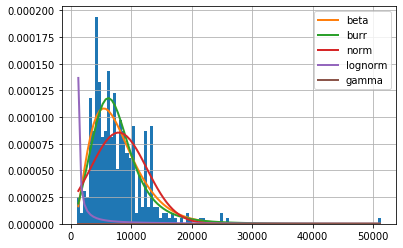

In [36]:
#from Fitter import fitter
f = Fitter(salario,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [66]:
f.get_best(method = 'sumsquare_error')

{'beta': (3.0970695201871736,
  108021734137.9241,
  309.90879658484994,
  264525778749264.88)}

In [67]:
f.fitted_param["burr"]


(3.854517242496353, 0.6229135099789088, -35.46867539819641, 8596.093626653574)

In [68]:
get_common_distributions()

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

,sumsquare_error,aic,bic,kl_div
chi2,3.160704e-08,3142.424456,-9019.927249,inf
rayleigh,3.697904e-08,3723.876818,-8964.829000,inf
norm,4.808826e-08,4379.231153,-8862.643804,inf
cauchy,5.083753e-08,2525.244953,-8841.016660,inf
expon,8.497814e-08,2500.243506,-8641.164348,inf


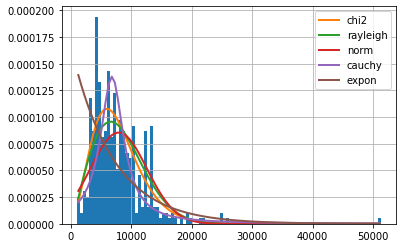

In [69]:
f = Fitter(salario, distributions= get_common_distributions())
f.fit()
f.summary()

In [70]:
f.get_best(method = 'sumsquare_error')


{'chi2': (9.610031179126544, -1107.511104946272, 928.4489478780638)}

In [37]:
# Shapiro-Wilk Test

#nenhum dos dados é parecido com gaussiana
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# generate univariate observations
data = 5 * randn(100) + 50
# normality test
stat, p = shapiro(df['Salario'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')
    
 # Shapiro-Wilk Test

Statistics=0.829, p=0.000
Sample does not look Gaussian (reject H0)


In [38]:
stats.zscore(df['Salario'])

0      0.146546
1     -0.219079
2     -0.409822
3      0.828933
4     -0.883678
         ...   
384    0.352505
385    0.227558
386    9.309259
387    0.459664
388   -1.452262
Name: Salario, Length: 389, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023AD95DB448>]],
      dtype=object)

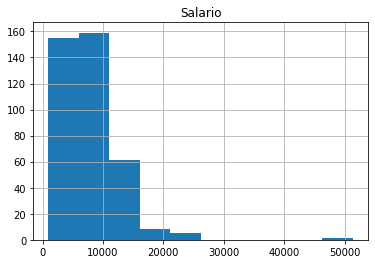

In [39]:
df.hist('Salario')

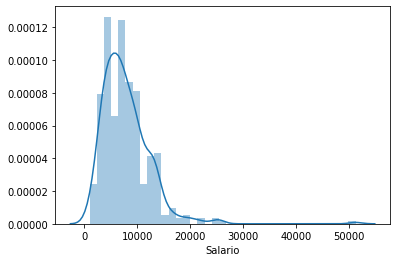

In [40]:
sns.distplot(df['Salario'])

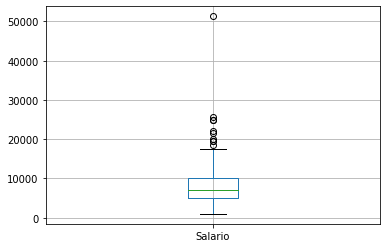

In [41]:
boxplot = df.boxplot(column=['Salario']) # tem q usar a remoção outlier, mas antes tem q ajeitar os valores ( /12)

# Divisão Em classes

In [42]:
dfj = df[df['Classe'] == 'Junior']
dfp = df[df['Classe'] == 'Pleno']
dfs = df[df['Classe'] == 'Senior']


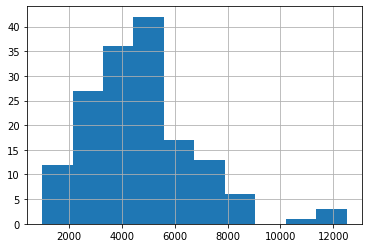

In [43]:
dfj['Salario'].hist()

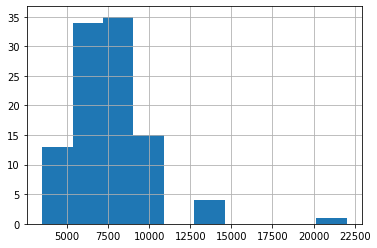

In [44]:
dfp['Salario'].hist()

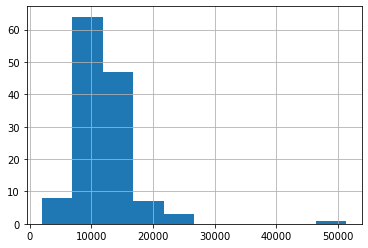

In [45]:
dfs['Salario'].hist()

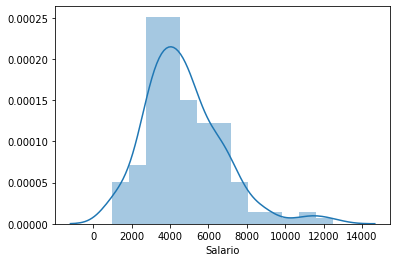

In [46]:
#junior
sns.distplot(dfj['Salario'])


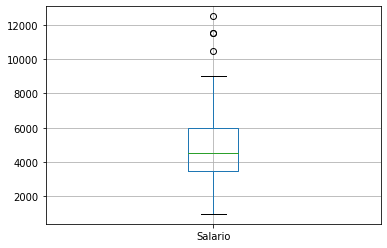

In [47]:
boxplot = dfj.boxplot(column=['Salario']) 

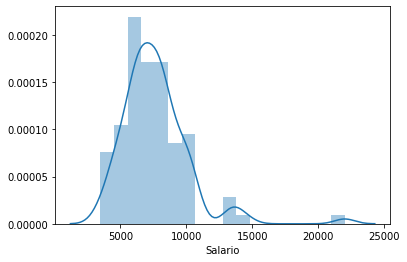

In [48]:
#Pleno
sns.distplot(dfp['Salario'])

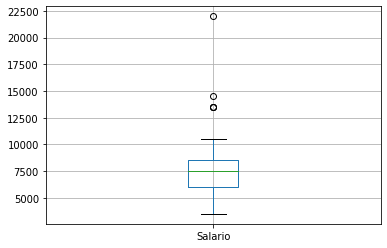

In [49]:
boxplot = dfp.boxplot(column=['Salario'])

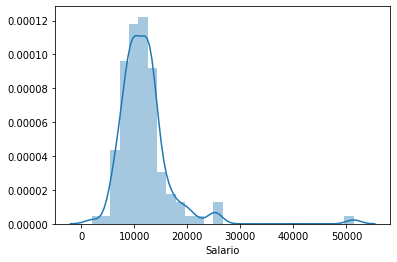

In [50]:
#Senior
sns.distplot(dfs['Salario'])

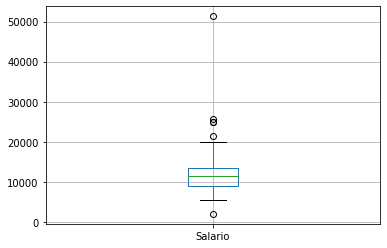

In [51]:
boxplot = dfs.boxplot(column=['Salario'])

# Técnicas de Visualização de Dados


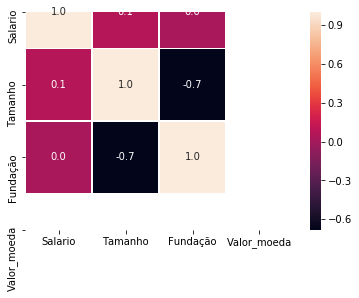

In [52]:
correlation = df.corr()
plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
plot

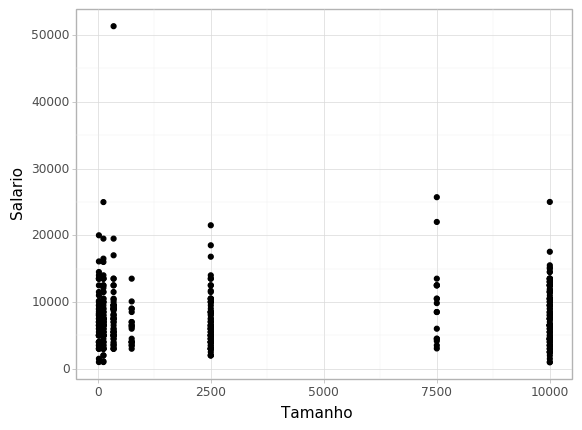

<ggplot: (-9223371883613139596)>

In [53]:
from plotnine.data import economics
from plotnine import *
(ggplot(df,aes('Tamanho','Salario'))#tamanho, setor,empresa,
 + geom_point()
 + theme_light()
)

C:\Users\Azzy\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:401: PlotnineWarning:

geom_point : Removed 108 rows containing missing values.



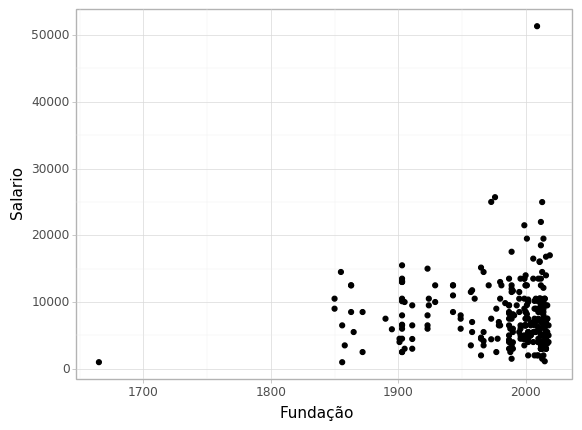

<ggplot: (-9223371883613096380)>

In [54]:
from plotnine import *

(ggplot(df,aes('Fundação','Salario'))
 + geom_point()
 + theme_light()
)

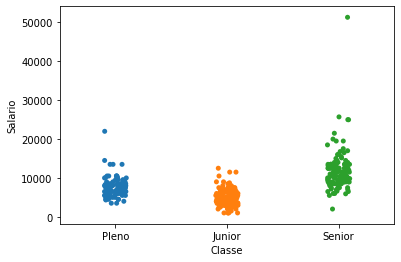

In [55]:
sns.stripplot(x='Classe', y='Salario', data=df)

In [56]:
df['Classe'] = [w.replace('Senior', '3') for w in df['Classe']]
df['Classe'] = [w.replace('Pleno', '2') for w in df['Classe']]
df['Classe'] = [w.replace('Junior', '1') for w in df['Classe']]
df['Classe'] = df['Classe'].astype(int)

In [57]:
import plotly.express as px

fig = px.parallel_coordinates(df, color="Classe")
fig.show()

In [58]:
import plotly.express as px

fig = px.scatter(df, x="Salario", y="Tamanho", color="Classe",
                 title="Salario/Tamanho")

fig.show()